In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
from pymongo import MongoClient
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from bornrule import BornClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load the Dataset into MongoDB

Dataset available for dowload [here](https://www.kaggle.com/datasets/shuyangli94/foodcom-recipes-with-search-terms-and-tags/data)

In [2]:
csv_path = os.path.expanduser("data/recipes.csv")
recipes_df = pd.read_csv(csv_path)
print(f"Loaded {len(recipes_df)} total recipes.")

cuisines = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']
recipes_df["ingredients"] = recipes_df["ingredients"].apply(ast.literal_eval)
recipes_df["steps"] = recipes_df["steps"].apply(ast.literal_eval)
recipes_df["search_terms"] = recipes_df["tags"].apply(
    lambda tags: [t for t in ast.literal_eval(tags) if t in cuisines]
)
filtered_df = recipes_df[recipes_df["search_terms"].apply(lambda x: len(x) > 0)]

records = []
for _, row in filtered_df.iterrows():
    record = {
        "recipe_id": int(row["id"]),
        "name": row.get("name", ""),
        "description": row.get("description", ""),
        "steps": row.get("steps", ""),
        "tags": row["tags"],
        "ingredients": row.get("ingredients", ""),
        "search_terms": row["search_terms"],
    }
    records.append(record)

client = MongoClient("mongodb://localhost:27017/")
db = client["cousine"]
collection = db["foodcom"]

collection.delete_many({})
collection.insert_many(records)

print(f"Inserted {collection.count_documents({})} filtered recipes into MongoDB 'cousine.foodcom'.")

Loaded 494963 total recipes.
Inserted 45117 filtered recipes into MongoDB 'cousine.foodcom'.


In [25]:
db = MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

## Tokenize the Dataset

Using a CountVectorizer, each ingredient becomes a token.

The result is:
* A Matrix **X** where each column is an ingredient and each row is a recipe
* A Matrix **y** where each column is a cousine and each row is a recipie (Only one "1" value per row)

In [26]:
tokenizer = lambda x: x.split("|")
ingredients_encoder = CountVectorizer(
    tokenizer=tokenizer,
    token_pattern=None,
    binary=True,
    min_df=20
)
labels_encoder = CountVectorizer(
    tokenizer=tokenizer,
    token_pattern=None,
    binary=True
)

In [35]:
X = ingredients_encoder.fit_transform(
    ["|".join(x['ingredients']) for x in data]
).toarray()
y = labels_encoder.fit_transform(
    [x[label_field] for x in data]
).toarray()

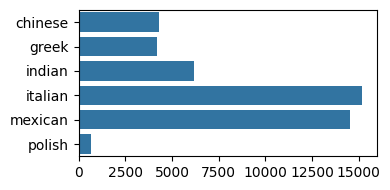

Features: (45117, 1819)
Labels: (45117, 6)


In [31]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=y.sum(axis=0), y=labels_encoder.get_feature_names_out(), ax=ax)
plt.tight_layout()
plt.show()

print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")

## Split the Dataset

In [34]:
labels = labels_encoder.get_feature_names_out()
y_true = [labels[int(np.where(a == 1)[0][0])] for a in y]

X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=.7)

## Classify

Using a Classic Classifier: BornClassifier

In [39]:
born = BornClassifier()
born.fit(X_train, y_train)

,a,0.5
,b,1.0
,h,1.0


In [40]:
y_pred = born.predict(X_test)

## Evaluate Classification

In [44]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     chinese       0.83      0.93      0.88      1285
       greek       0.61      0.76      0.67      1268
      indian       0.86      0.88      0.87      1835
     italian       0.94      0.79      0.86      4592
     mexican       0.97      0.86      0.91      4355
      polish       0.18      0.81      0.29       201

    accuracy                           0.84     13536
   macro avg       0.73      0.84      0.75     13536
weighted avg       0.89      0.84      0.85     13536



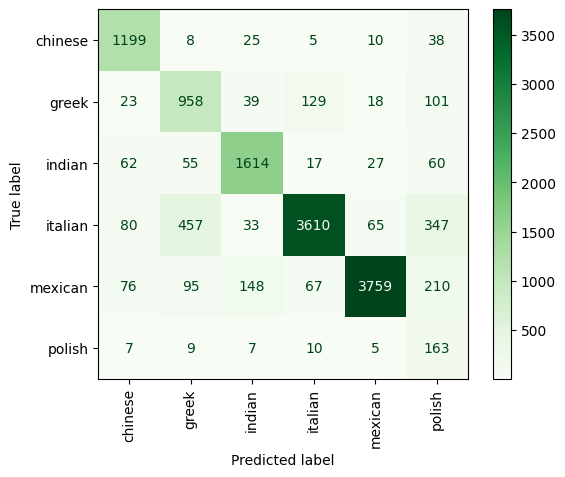

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.show()

## Analysing Explainability

### Local Explanation

Why did the model pick italian on this specific recipe?

In [46]:
test_recipe = ['potatoes', 'onions', 'salt', 'mushrooms', 'olive oil', 'soy sauce']
vector = ingredients_encoder.transform(["|".join(test_recipe)]).toarray()
print(born.predict(vector)[0])
print(pd.Series(born.predict_proba(vector)[0], index=labels))

chinese
chinese    0.566711
greek      0.123899
indian     0.079301
italian    0.084006
mexican    0.059860
polish     0.086222
dtype: float64


In [50]:
local_explain = pd.DataFrame(born.explain(vector), index=ingredients_encoder.get_feature_names_out(), columns=labels)

local_explain['chinese'].sort_values(ascending=False).head(10)

soy sauce                     0.073496
olive oil                     0.005954
potatoes                      0.002503
mushrooms                     0.001665
onions                        0.001366
salt                          0.001236
parsley flakes                0.000000
parsley                       0.000000
parmigiano-reggiano cheese    0.000000
parmigiano                    0.000000
Name: chinese, dtype: float64

### Global Explanation

What are the ingredients that mostly influence the prediction of "italian" across the recipes?

In [54]:
global_explain = pd.DataFrame(born.explain(X_test), index=ingredients_encoder.get_feature_names_out(), columns=labels)

In [55]:
global_explain.sort_values(by='italian', ascending=False).head(10)

,chinese,greek,indian,italian,mexican,polish
parmesan cheese,0.053022,0.598977,0.118909,1.405353,0.264483,0.319699
olive oil,0.270635,0.974002,0.394450,0.861254,0.490866,0.279790
mozzarella cheese,0.055953,0.199433,0.046935,0.533905,0.161178,0.123125
extra virgin olive oil,0.081054,0.386369,0.115925,0.446553,0.157013,0.105727
fresh basil,0.055601,0.191966,0.052925,0.358338,0.062007,0.045262
butter,0.127712,0.257168,0.220543,0.277793,0.190315,0.438814
italian seasoning,0.000000,0.102851,0.000000,0.268320,0.043182,0.000000
dried oregano,0.017881,0.364954,0.039287,0.255169,0.206156,0.038011
ricotta cheese,0.018632,0.110759,0.037501,0.231940,0.046160,0.057157
spaghetti sauce,0.000000,0.026248,0.027100,0.210554,0.032935,0.066266
